#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/nhc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
4780,27/07/2022,4.50,4.55,4.45,4.46,4.46,2042511.0,1.35,2.5,125.0
4781,28/07/2022,4.50,4.50,4.34,4.39,4.39,2476680.0,1.35,2.5,125.0
4782,29/07/2022,4.45,4.49,4.38,4.39,4.39,2947903.0,1.35,2.5,125.0
4783,1/08/2022,4.42,4.43,4.36,4.40,4.40,1752248.0,1.35,2.5,125.0
4784,2/08/2022,4.34,4.36,4.27,4.31,4.31,2512386.0,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
# db.nhc.drop()

# # Insert all the records in the CSV into MongoDb
# records=df.to_dict('records')
# records
# db.nhc.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nhc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.nhc.delete_one(
    {'Date': last_date}
)


DELETE: 2/08/2022 4.31


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nhc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

NEW LAST VALUE IN MONGODB: 1/08/2022 4.4


In [7]:
from datetime import date,datetime
todaydt = date.today()

today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)


Last date in MongoDb: 01-08-2022. Today's date: 03-08-2022


UPDATE MONGO DB

In [8]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'NHC.AX'
start = from_date # yyyy-mm-dd
start='2022-07-14'
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-15,4.230,4.09,4.16,4.18,4250406,4.18
2022-07-18,4.430,4.23,4.35,4.30,4986337,4.30
2022-07-19,4.525,4.32,4.34,4.45,6553673,4.45
2022-07-20,4.500,4.40,4.50,4.47,3289783,4.47
2022-07-21,4.580,4.34,4.50,4.39,4412760,4.39
2022-07-22,4.350,4.21,4.28,4.29,2636664,4.29
2022-07-25,4.410,4.30,4.30,4.35,2381637,4.35
2022-07-26,4.510,4.37,4.40,4.48,2296524,4.48
2022-07-27,4.550,4.45,4.50,4.46,2042511,4.46


In [9]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,15/07/2022,4.230,4.09,4.16,4.18,4250406,4.18,1.35,2.5,125
1,18/07/2022,4.430,4.23,4.35,4.30,4986337,4.30,1.35,2.5,125
2,19/07/2022,4.525,4.32,4.34,4.45,6553673,4.45,1.35,2.5,125
3,20/07/2022,4.500,4.40,4.50,4.47,3289783,4.47,1.35,2.5,125
4,21/07/2022,4.580,4.34,4.50,4.39,4412760,4.39,1.35,2.5,125
5,22/07/2022,4.350,4.21,4.28,4.29,2636664,4.29,1.35,2.5,125
6,25/07/2022,4.410,4.30,4.30,4.35,2381637,4.35,1.35,2.5,125
7,26/07/2022,4.510,4.37,4.40,4.48,2296524,4.48,1.35,2.5,125
8,27/07/2022,4.550,4.45,4.50,4.46,2042511,4.46,1.35,2.5,125
9,28/07/2022,4.500,4.34,4.50,4.39,2476680,4.39,1.35,2.5,125


In [10]:
records=stock_quote.to_dict('records',)
print(records)

[{'Date': '15/07/2022', 'High': 4.230000019073486, 'Low': 4.090000152587891, 'Open': 4.159999847412109, 'Close': 4.179999828338623, 'Volume': 4250406, 'Adj Close': 4.179999828338623, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '18/07/2022', 'High': 4.429999828338623, 'Low': 4.230000019073486, 'Open': 4.349999904632568, 'Close': 4.300000190734863, 'Volume': 4986337, 'Adj Close': 4.300000190734863, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '19/07/2022', 'High': 4.525000095367432, 'Low': 4.320000171661377, 'Open': 4.340000152587891, 'Close': 4.449999809265137, 'Volume': 6553673, 'Adj Close': 4.449999809265137, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '20/07/2022', 'High': 4.5, 'Low': 4.400000095367432, 'Open': 4.5, 'Close': 4.46999979019165, 'Volume': 3289783, 'Adj Close': 4.46999979019165, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}, {'Date': '21/07/2022', 'High': 4.579999923706055, 'Low': 4.340000152587891, 'Open': 4.5, 'Close': 4.389999866485596, 'Volume': 4412760, 'Adj Close': 

In [11]:
#INSERT NEW DATA INTO MONGODB
db.nhc.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.nhc.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62e9aaeb7f7a405329904b5f'), '20/07/2022', 4.5, 4.5,
        4.400000095367432, 4.46999979019165, 4.46999979019165, 3289783.0,
        1.35, 2.5, 125.0],
       [ObjectId('62e9aaeb7f7a405329904b60'), '21/07/2022', 4.5,
        4.579999923706055, 4.340000152587891, 4.389999866485596,
        4.389999866485596, 4412760.0, 1.35, 2.5, 125.0],
       [ObjectId('62e9aaeb7f7a405329904b61'), '22/07/2022',
        4.28000020980835, 4.349999904632568, 4.210000038146973,
        4.289999961853027, 4.289999961853027, 2636664.0, 1.35, 2.5,
        125.0],
       [ObjectId('62e9aaeb7f7a405329904b62'), '25/07/2022',
        4.300000190734863, 4.409999847412109, 4.300000190734863,
        4.349999904632568, 4.349999904632568, 2381637.0, 1.35, 2.5,
        125.0],
       [ObjectId('62e9aaeb7f7a405329904b63'), '26/07/2022',
        4.400000095367432, 4.510000228881836, 4.369999885559082,
        4.480000019073486, 4.480000019073486, 2296524.0, 1.35, 2.5,
        125.0],
       [ObjectId

In [12]:
import pandas as pd
df_mongo = pd.DataFrame(list(db.nhc.find()))
last_val_10 = df_mongo.iloc[-1:].values
last_date = last_val_10[-1][1]
last_close = last_val_10[-1][5]
print(last_close,last_date)

4.309999942779541 02/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.nhc.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
# df_mongo["Close"]=df_mongo["Close"].astype(float)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(4792, 1)

In [14]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [15]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(3834, 1)

In [16]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.02341137, 0.01672241, 0.01505017, 0.01505017, 0.01672241,
       0.01337793, 0.00668896, 0.01003344, 0.01170569, 0.00668896,
       0.0083612 , 0.0083612 , 0.00668896, 0.01170569, 0.01672241,
       0.01505017, 0.01505017, 0.01505017, 0.01170569, 0.01003344,
       0.01170569, 0.01170569, 0.01170569, 0.01003344, 0.0083612 ,
       0.0083612 , 0.01003344, 0.01337793, 0.01003344, 0.0083612 ,
       0.01003344, 0.0083612 , 0.0083612 , 0.0083612 , 0.0083612 ,
       0.0083612 , 0.0083612 , 0.01003344, 0.00668896, 0.0083612 ,
       0.0083612 , 0.0083612 , 0.00167224, 0.00167224, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00668896, 0.00167224, 0.        , 0.        ,
       0.00167224, 0.        , 0.00167224, 0.01337793, 0.00501672])]
[0.010033444816053505]


# Prepare train data for LSTM model

In [17]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(3774, 60)

In [18]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3774, 60, 1)

# Build the LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3774/3774 [==============================] - 61s 16ms/step - loss: 0.0011


In [22]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [23]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [24]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.08237661238751981

C:\Users\antoi\AppData\Local\Temp/ipykernel_14184/1322726253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


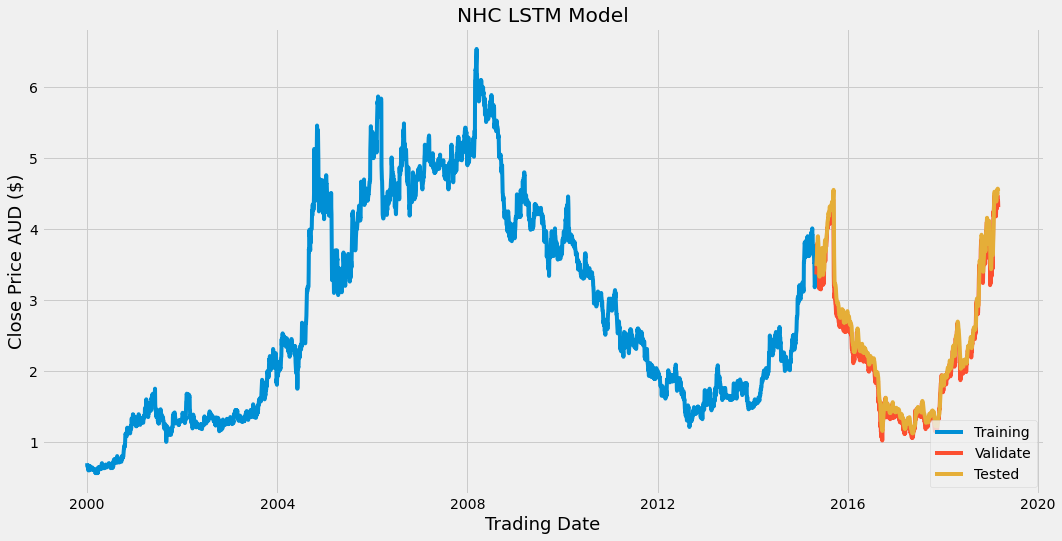

In [26]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NHC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nhc_graph.png')
plt.show()

# Test data Predictions on the Model

In [27]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_14184/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of       Close  Predictions  Difference
3834   3.36     3.480037   -0.120037
3835   3.39     3.499700   -0.109700
3836   3.52     3.520088   -0.000088
3837   3.59     3.577397    0.012603
3838   3.64     3.649508   -0.009508
...     ...          ...         ...
4787   4.46     4.532117   -0.072117
4788   4.39     4.570203   -0.180203
4789   4.39     4.566309   -0.176310
4790   4.40     4.550635   -0.150635
4791   4.31     4.540230   -0.230230

[958 rows x 3 columns]>

In [28]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.nhc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [29]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [30]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $4.309999942779541 Predicted next day share price $4.47


# Save the Model

In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nhc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list nhc_sixty and load df

#PREDICT USING LOADED MODEL

In [32]:
from keras.models import load_model
model_in = load_model('../static/nhc_model.sav')

In [33]:
# query the nhc collection and load into dataframe

df_mongo = pd.DataFrame(list(db.nhc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[3.56      ],
       [3.8       ],
       [3.58      ],
       [3.66      ],
       [3.67      ],
       [3.76      ],
       [3.84      ],
       [3.91      ],
       [3.95      ],
       [3.94      ],
       [3.84      ],
       [3.76      ],
       [3.51      ],
       [3.61      ],
       [3.68      ],
       [3.62      ],
       [3.14      ],
       [3.19      ],
       [3.27      ],
       [3.31      ],
       [3.2       ],
       [3.24      ],
       [3.41      ],
       [3.61      ],
       [3.46      ],
       [3.32      ],
       [3.46      ],
       [3.6       ],
       [3.45      ],
       [3.38      ],
       [3.55      ],
       [3.66      ],
       [3.835     ],
       [3.87      ],
       [4.2       ],
       [4.09      ],
       [4.23      ],
       [4.32      ],
       [4.4       ],
       [4.34      ],
       [4.21      ],
       [4.3       ],
       [4.37      ],
       [4.45      ],
       [4.34      ],
       [4.38      ],
       [4.36      ],
       [4.090

In [34]:
# workings for scatterplot
# df_mongo_nhc = pd.DataFrame(list(db.nhc.find()))
# df_nhc = df_mongo_nhc.iloc[-4250:]
# nhc_dict = df_nhc.to_dict(orient='records')
# #print(nhc_dict)

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/nhc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# # Read in the CSV file
# nhcdump = pd.read_csv("../static/data/nhc.csv")
# nhcdump = nhcdump.dropna()
# nhcdump_sixty = nhcdump.iloc[-4250:]
# sixty_val = nhcdump_sixty.iloc[-60:,4].values
# last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_nhc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_nhc(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[4.35,
 4.34,
 4.35,
 4.36,
 4.37,
 4.39,
 4.41,
 4.43,
 4.45,
 4.47,
 4.49,
 4.5,
 4.52,
 4.53,
 4.55,
 4.56,
 4.57,
 4.58,
 4.59,
 4.61,
 4.62,
 4.63,
 4.64,
 4.65,
 4.66,
 4.67,
 4.68,
 4.69,
 4.71,
 4.72,
 4.73,
 4.74,
 4.74,
 4.75,
 4.75,
 4.75,
 4.76,
 4.76,
 4.76,
 4.77,
 4.77,
 4.78,
 4.78,
 4.79,
 4.79,
 4.8,
 4.81,
 4.82,
 4.82,
 4.83,
 4.83,
 4.84,
 4.85,
 4.85,
 4.86,
 4.86,
 4.87,
 4.87,
 4.88,
 4.88,
 4.88,
 4.89,
 4.89,
 4.9,
 4.9,
 4.91,
 4.91,
 4.91,
 4.92,
 4.92,
 4.93,
 4.93,
 4.93,
 4.94,
 4.94,
 4.94,
 4.94,
 4.95,
 4.95,
 4.95,
 4.95,
 4.96,
 4.96,
 4.96,
 4.97,
 4.97,
 4.97,
 4.97,
 4.97,
 4.98,
 4.98,
 4.98,
 4.98,
 4.98,
 4.99,
 4.99,
 4.99,
 4.99,
 4.99,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.01,
 5.01,
 5.01,
 5.01,
 5.01,
 5.01,
 5.01,
 5.02,
 5.02,
 5.02,
 5.02,
 5.02,
 5.02,
 5.02,
 5.02,
 5.03,
 5.03,
 5.03,
 5.03,
 5.03,
 5.03,
 5.03,
 5.03,
 5.03,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.04,
 5.05,
 5.05,
 5.05,
 5.05,
 

In [36]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df


,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_14184/1742249948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list
C:\Users\antoi\AppData\Local\Temp/ipykernel_14184/1742249948.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../static/data/images/pred/nhc_pred.png', bbox_inhces="tight")


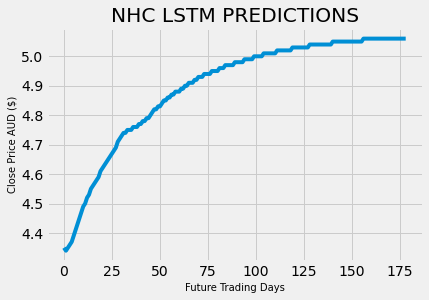

In [37]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('NHC LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/nhc_pred.png', bbox_inhces="tight")
plt.show()

In [38]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 4.35},
 {'Price': 4.34},
 {'Price': 4.35},
 {'Price': 4.36},
 {'Price': 4.37},
 {'Price': 4.39},
 {'Price': 4.41},
 {'Price': 4.43},
 {'Price': 4.45},
 {'Price': 4.47},
 {'Price': 4.49},
 {'Price': 4.5},
 {'Price': 4.52},
 {'Price': 4.53},
 {'Price': 4.55},
 {'Price': 4.56},
 {'Price': 4.57},
 {'Price': 4.58},
 {'Price': 4.59},
 {'Price': 4.61},
 {'Price': 4.62},
 {'Price': 4.63},
 {'Price': 4.64},
 {'Price': 4.65},
 {'Price': 4.66},
 {'Price': 4.67},
 {'Price': 4.68},
 {'Price': 4.69},
 {'Price': 4.71},
 {'Price': 4.72},
 {'Price': 4.73},
 {'Price': 4.74},
 {'Price': 4.74},
 {'Price': 4.75},
 {'Price': 4.75},
 {'Price': 4.75},
 {'Price': 4.76},
 {'Price': 4.76},
 {'Price': 4.76},
 {'Price': 4.77},
 {'Price': 4.77},
 {'Price': 4.78},
 {'Price': 4.78},
 {'Price': 4.79},
 {'Price': 4.79},
 {'Price': 4.8},
 {'Price': 4.81},
 {'Price': 4.82},
 {'Price': 4.82},
 {'Price': 4.83},
 {'Price': 4.83},
 {'Price': 4.84},
 {'Price': 4.85},
 {'Price': 4.85},
 {'Price': 4.86},
 {'Price': 4

In [39]:
len_df_mongo=len(df_mongo)
# df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

3834 4792 4960


,Close
4949,5.06
4950,5.06
4951,5.06
4952,5.06
4953,5.06
4954,5.06
4955,5.06
4956,5.06
4957,5.06
4958,5.06


C:\Users\antoi\AppData\Local\Temp/ipykernel_14184/3284421698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


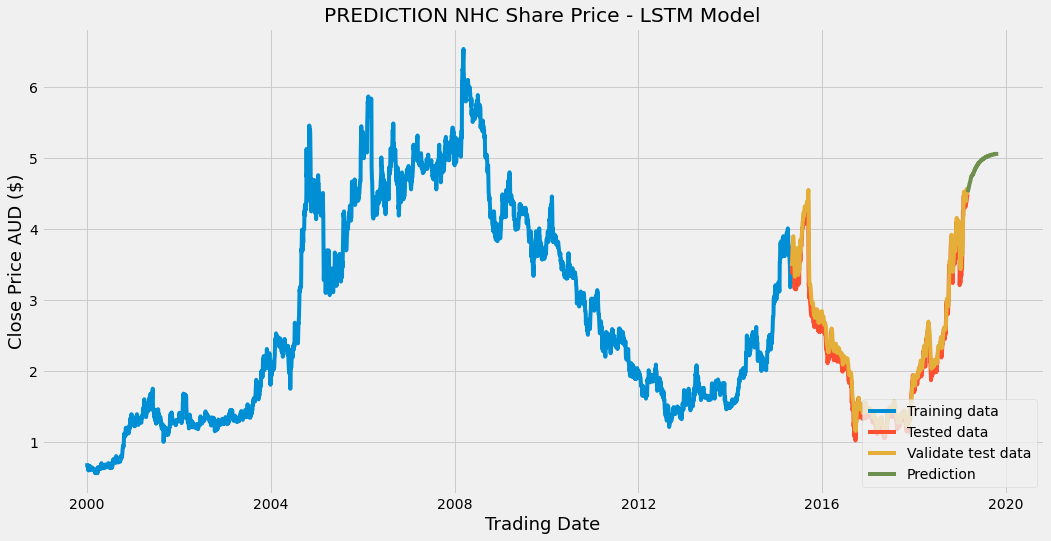

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION NHC Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nhc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [41]:
# # Module used to connect Python with MongoDb
# import pymongo
# # The default port used by MongoDB is 27017
# # https://docs.mongodb.com/manual/reference/default-mongodb-port/
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)

# # Define the 'sharesDB' database in Mongo and connect to the company collection
# db = client.sharesDB.companys


In [42]:
# Query collection companys
name = 'NHC'
companys = db.companys.find({'name': name})

# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 4, 'actual': 4.4, 'differece': -0.15000000000000036, 'rmse': 0.04529}
{'_id': ObjectId('62e36c15061c0e61acc858fc'), 'model': 'RFR', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 3.57, 'actual': 4.4, 'differece': -0.83, 'accuracy': 95.24}


In [43]:
# Set keys and values of company
last_close=round(float(last_close),2)
predicted = int(pred_price)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022, predicted $4.47, actual $4.31, difference 0.16000000000000014, rmse 0.08238


In [44]:
# Delete a document from a collection for update
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e36c15061c0e61acc858fc'), 'model': 'RFR', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 3.57, 'actual': 4.4, 'differece': -0.83, 'accuracy': 95.24}


In [45]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': predicted,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)
# query the collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e36c15061c0e61acc858fc'), 'model': 'RFR', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 3.57, 'actual': 4.4, 'differece': -0.83, 'accuracy': 95.24}
{'_id': ObjectId('62e9ab377f7a405329904b69'), 'model': 'LSTM', 'name': 'NHC', 'date': '02/08/2022', 'predicted': 4, 'actual': 4.31, 'difference': 0.16, 'rmse': 0.08238}


In [46]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 31, 'actual': 21, 'differece': 10.425907785164608, 'accuracy': 97.16}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07